<a href="https://colab.research.google.com/github/aserravalle/Stock-Prediction-Linear-Regression/blob/master/StockPreds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [263]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.to_csv('/content/AAPLstock.csv', index = False)

print(df.shape)
df.head()

(1769, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,30.642857,30.340000,30.490000,30.572857,123432400.0,26.681330
2010-01-05,30.798571,30.464285,30.657143,30.625713,150476200.0,26.727465
2010-01-06,30.747143,30.107143,30.625713,30.138571,138040000.0,26.302330
2010-01-07,30.285715,29.864286,30.250000,30.082857,119282800.0,26.253704
2010-01-08,30.285715,29.865715,30.042856,30.282858,111902700.0,26.428249


In [0]:
def BuildPipeline(stock, start, end):
  # Load data
  df = web.DataReader(stock, 'yahoo', start, end) 
    # Note that start date won't appear in output - it will be dropped for rolling avgs
    # Set start date 1.5y before you actually want the data to start
  df.to_csv('/content/'+stock+'stock.csv', index = False)

  # Target 
  close_px = df['Adj Close']

  # Moving Average
  df['mavg50'] = close_px.rolling(window = 50).mean()
  df['mavg100'] = close_px.rolling(window = 100).mean()
  df['mavg200'] = close_px.rolling(window = 200).mean()

  # Return
  df['rets_day'] = close_px / close_px.shift(1) - 1
  df['rets_week'] = close_px / close_px.shift(7) - 1
  df['rets_month'] = close_px / close_px.shift(30) - 1
  df['rets_year'] = close_px / close_px.shift(365) - 1

  # Competitor stock prices
  competitors = ['GE', 'GOOG', 'IBM', 'MSFT']
  dfcomp = web.DataReader(competitors,'yahoo',start=start,end=end)['Adj Close']
  dfcomp.index = df.index
  df = pd.concat([df, dfcomp], axis =1)

  # Rolling correlation between AAPL and competitors
  for comp in competitors:
    df['Corr: '+comp] = df['Adj Close'].rolling(90).corr(df[comp])

  # Adjust the timing to reflect data you will have
  reg_df = df['Open'][1:] # Today's open
  shift = df.iloc[:len(df) - 1, :] #Previous everything else

  lagging_features = [col for col in df.columns if col not in ['Open','Close']]
  shift = shift.loc[:, lagging_features] #Drop Open and Close
  shift.index = reg_df.index # Set index from yesterday's date to todays date, become "previous"
  df = pd.concat([reg_df, shift], axis = 1, ) # Join the two dataframes 

  # Drop early missing values
  df.dropna(axis = 0, inplace = True)

  return df

In [265]:
# Load training data
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = BuildPipeline("AAPL", start, end)
print(df.shape)
df.head()

(1403, 20)


,Open,High,Low,Volume,Adj Close,mavg50,mavg100,mavg200,rets_day,rets_week,rets_month,rets_year,GE,GOOG,IBM,MSFT,Corr: GE,Corr: GOOG,Corr: IBM,Corr: MSFT
Date,,,,,,,,,,,,,,,,,,,,
2011-06-16,46.700001,47.185715,46.411430,99799000.0,40.737003,42.340529,42.853248,40.536488,-0.017116,-0.033398,-0.061602,0.526798,13.440412,250.535934,123.620567,19.379145,0.719063,0.606507,0.016047,0.696665
2011-06-17,46.998573,46.954285,45.475716,127647800.0,40.538776,42.306294,42.837926,40.587641,-0.004866,-0.020720,-0.069829,0.516746,13.587784,249.250748,123.879501,19.591385,0.727901,0.615920,0.026176,0.710444
2011-06-20,45.337143,47.035713,45.622856,153755000.0,39.927876,42.261960,42.811570,40.631233,-0.015070,-0.036059,-0.076395,0.518036,13.624629,241.604401,125.227402,19.803619,0.733229,0.628033,0.020691,0.713223
2011-06-21,45.240002,45.385715,44.357143,160161400.0,39.311993,42.205209,42.776001,40.670599,-0.015425,-0.048780,-0.090406,0.497388,13.617256,241.385223,125.669083,19.975054,0.734932,0.638165,0.015521,0.700132
2011-06-22,46.451427,46.542858,45.028572,123345600.0,40.556232,42.180873,42.753672,40.712071,0.031650,-0.001841,-0.064154,0.534579,13.860425,245.579514,126.582932,20.211779,0.735236,0.642829,0.009150,0.694167


In [266]:
# Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Separate training and evaluating data
X = df.drop('Adj Close', axis = 1)
y = df[['Adj Close']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

print('done')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.17527e-36): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/ridge.py:189: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


done


In [267]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

# results
print('Confidence intervals')
print('Linear Reg :', confidencereg)
print('Quad Reg1  :', confidencepoly2)
print('Quad Reg2  :', confidencepoly3)
print('KNN Reg    :', confidenceknn)

Confidence intervals
Linear Reg : 0.9992078377025347
Quad Reg1  : 0.9997040960597591
Quad Reg2  : 0.4939750926841152
KNN Reg    : 0.254757138848678


In [0]:
# Rebuild model on full training set
# Linear regression
clfreg = LinearRegression(n_jobs = -1)
clfreg.fit(X, y)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X, y)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X, y)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X, y)
print('done')

In [283]:
start = datetime.datetime(2015, 8, 1) # Set early to start after training data
end = datetime.datetime(2019, 6, 30)

test = BuildPipeline("AAPL", start, end)
print(test.shape)

# Split data
y_test = test[['Adj Close']]
X_test = test.drop('Adj Close', axis = 1)
y_test_predictions = []

# Make predictions on later data
for i in range(len(X_test)):
  X_obs = X_test.iloc[i,:]
  X_obs = np.array(X_obs).reshape(1, -1)

  yhat = clfreg.predict(X_obs)[0][0]
  y_test_predictions.append(yhat)

# Append predictions to actual data
y_test['Prediction'] = pd.DataFrame({'Prediction' : y_test_predictions}, index = y_test.index)

y_test.tail()

(618, 20)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Adj Close,Prediction
Date,,
2019-06-24,198.027603,200.632745
2019-06-25,197.828369,200.684364
2019-06-26,194.829758,198.652211
2019-06-27,199.043747,201.080052
2019-06-28,198.983978,201.330058


In [0]:
yhat = clfreg.predict(X_test)

In [286]:
# Test the performance of models on testing data
confidencereg = clfreg.score(X_test, y_test['Adj Close'])
confidencepoly2 = clfpoly2.score(X_test,y_test['Adj Close'])
confidencepoly3 = clfpoly3.score(X_test,y_test['Adj Close'])
confidenceknn = clfknn.score(X_test, y_test['Adj Close'])

# Results
print('Confidence intervals')
print('Linear Reg :', confidencereg)
print('Quad Reg1  :', confidencepoly2)
print('Quad Reg2  :', confidencepoly3)
print('KNN Reg    :', confidenceknn)


Confidence intervals
Linear Reg : 0.9949704062598604
Quad Reg1  : 0.1330740247172567
Quad Reg2  : -7.629004540871198
KNN Reg    : -7.096528477694136


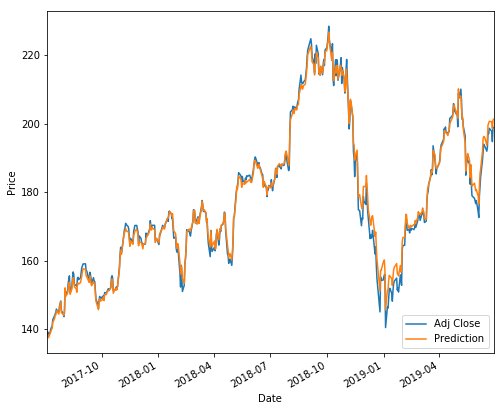

In [287]:
y_test['Adj Close'].tail(500).plot()
y_test['Prediction'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()